# BMI and Age relationship to cell proportions in Schildkraut HGSOC

### Exploratory rank-correlation screen

Cell-fraction estimates (Adipocytes, Immune, Stromal, Epithelial) were first explored with non-parametric Spearman correlations against two continuous host variables—body-mass index (BMI, kg m⁻²) and age (yr). Spearman’s ρ captures monotonic trends without assuming linearity or normal residuals. Each of the four fractions was correlated separately with BMI and with age (eight tests total). Raw p-values were Bonferroni-adjusted (α/8) to control the family-wise error rate for this exploratory screen.

### Confirmatory beta-regression modelling

Because the fractions are bounded in (0, 1) and heteroscedastic, we modelled each macro-fraction with a mean-only beta regression (logit link) using BetaModel from statsmodels 0.14. Predictors were z-standardised BMI and z-standardised age, entered simultaneously to obtain mutually adjusted effect estimates. For fraction f in sample i the model is

logit(μ_f) = β0 + βBMI · zBMI + βAge · zAge

where μ_f is the expected fraction, zBMI and zAge are the standardised predictors, and β’s are maximum-likelihood estimates. Wald 95 % confidence intervals and p-values were extracted for βBMI and βAge; the same Bonferroni adjustment (eight tests) controlled the family-wise error rate.

In [1]:
import pandas as pd
import numpy as np
from lifelines.utils import k_fold_cross_validation
import matplotlib.pyplot as plt
import os 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind
import sys 
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../')

import src.hp as hp

np.random.seed(88)

## Load survival metadata

In [2]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx") 

clr = False

remove_treatment = False
remove_pts_with_unknowns= True

map_stage = True
remove_unknown_stage = True
remove_999_BMI = True

In [3]:
fractions  = ["Adipocytes", "Immune", "Stromal", "Epithelial"]

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [4]:
props = pd.read_csv(os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


In [5]:
## The order for the plots:
desired_order = [
    'Age',
    'BMI',
    'No Adj Tx.',
    'Race: Black',
    'Residual: < 1cm',
    'Residual: ≥ 1cm',
    'Residual: Unknown size',
]
if remove_treatment:
    desired_order.remove('No Adj Tx.')
    desired_order.remove('Residual: < 1cm')
    desired_order.remove('Residual: ≥ 1cm')
    desired_order.remove('Residual: Unknown size')
desired_order

['Age',
 'BMI',
 'No Adj Tx.',
 'Race: Black',
 'Residual: < 1cm',
 'Residual: ≥ 1cm',
 'Residual: Unknown size']

### Build the analysis table  (clinical + cell fractions)


In [6]:
renaming = {"suid"          : "ID",
                   "refage"        : "Age",
                   "vital_status_fin": "Event",
                   "years_extend"  : "Time_Yrs",
                    "tissue"  : "Tissue",
                   "stage"         : "Stage",
                   "race"          : "Race",
                   "dblk_treat"    : "Debulk",
                   "hispanic"      : "Hispanic",
                   "bmi_recent"    : "BMI",
                   "neoadj_treat" : "NeoTx",
                   "adj_treat"     : "AdjTx",
                   "resdis_treat"  : "Residual"}

In [7]:
tissue_dictionary = {"right ovary": "Ovary",
                     "left ovary": "Ovary",
                     "ovary": "Ovary",
                      "left ovarian mass": "Ovary",
                     "right fallopian tube": "Fallopian Tube",
                     "left fallopian tube": "Fallopian Tube",
                     "fallopian tube": "Fallopian Tube",
                     "left fallopian tube and ovary": "Fallopian Tube and Ovary",
                     "right fallopian tube and ovary": "Fallopian Tube and Ovary",
                     "right ovary and fallopian tube": "Fallopian Tube and Ovary",
                     "left ovary and fallopian tube": "Fallopian Tube and Ovary",
                     "bilateral tubes and ovaries: tumor including possible ovarian tissue": "Fallopian Tube and Ovary",
                     "tubes and ovaries/cancer": "Fallopian Tube and Ovary",
                     "fallopian tube and ovary": "Fallopian Tube and Ovary",
                     "omentum": "Omentum",
                     "omental tumor": "Omentum",
                     "omentum (note: ovarian primary)": "Omentum",
                     "omentum or peritoneum": "Omentum",
                     "peritoneum or omentum": "Omentum",
                     "omentum or cul-de-sac implant": "Omentum",
                     "umbilicus": "Other",
                     "left ovary with adherent omentum": "Other",
                     "representative section of mesenteric nodule": "Other",
                     "representative section of mesenteric nodule": "Other",
                     "representative sections of tumor":  "Other",
                     "posterior wall of myometrium": "Other",
                     "left ovary and peritoneum": "Other",
                     "omentum or ovary": "Other",
                     "fallopian tube or ovary": "Other",
                     "cervix and colon": "Other",
                     "probable adnexal structure with papillary mass": "Other",
                     "peritoneum": "Other",
                    }

cont_cols = ["Age", "BMI"]

Metadata

In [8]:
meta_full = hp.open_and_clean_meta(meta_path=meta_path,
                                    renaming=renaming, 
                                    tissue_dictionary=tissue_dictionary)

In [9]:
# 999 if unknown BMI, we won't use for BMI and Age analysis.
if remove_999_BMI:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["BMI"]!=999]
    print("Removed for BMI 999: ",
           first-meta_full.shape[0])

Removed for BMI 999:  13


In [10]:
#match index in both
meta_full.index = meta_full.ID
props.index = props.ID
props.drop(columns=["ID", "SampleID", "suid"], inplace=True)

## and merge:
df = meta_full.join(props, how="inner")

cell_types = [col for col in df.columns if col not in meta_full.columns and col not in cont_cols]
cell_types.remove("Dataset")

df

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,BMI,AdjTx,Residual,...,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset
ID,,,,,,,,,,,,,,,,,,,,,
40143,40143,63,1,8.739220,NaN,3,1,23.218229,1.0,4.0,...,9.808751e-12,0.610632,1.004328e-110,2.784970e-66,3.408820e-86,2.396804e-02,1.848657e-50,0.0,0.113422,SchildkrautW
41377,41377,54,1,1.180014,NaN,3,1,17.428942,NaN,3.0,...,1.760940e-62,0.702189,1.298550e-208,3.770200e-114,5.097006e-86,1.148229e-151,2.716906e-120,0.0,0.169611,SchildkrautW
41387,41387,55,1,11.983573,NaN,3,2,45.470350,1.0,2.0,...,1.680504e-02,0.725604,1.103526e-97,9.654211e-04,3.169795e-58,6.457394e-02,9.868737e-88,0.0,0.064832,SchildkrautB
41391,41391,60,1,4.993840,NaN,3,1,31.340800,NaN,3.0,...,2.241865e-19,0.660983,3.521124e-102,3.787996e-28,1.975079e-50,1.760802e-02,3.608451e-57,0.0,0.119373,SchildkrautW
41435,41435,59,1,4.057495,NaN,3,1,23.922658,NaN,NaN,...,4.262662e-11,0.739953,8.402589e-122,2.637763e-60,2.022724e-88,5.507985e-03,3.092821e-03,0.0,0.110333,SchildkrautW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310266,310266,40,0,9.702186,Fallopian Tube,3,2,28.349557,NaN,NaN,...,1.374198e-10,0.777904,3.501752e-85,4.856912e-52,2.991107e-53,1.842305e-02,3.506149e-04,0.0,0.097551,SchildkrautB
320012,320012,66,0,11.767760,NaN,3,2,37.677475,1.0,4.0,...,1.048037e-48,0.771372,3.272227e-203,2.444034e-102,2.676690e-115,2.749868e-124,8.635726e-145,0.0,0.135411,SchildkrautB
320025,320025,60,1,6.827869,Other,3,2,38.740537,1.0,3.0,...,6.829921e-59,0.660166,6.138234e-174,1.089373e-96,7.514971e-104,2.901155e-89,6.676818e-64,0.0,0.181209,SchildkrautB


In [11]:
## Which cell types to use
immune_cells = ["B cells",
                    'Mast cells',
                    'T cells',
                    'Monocytes',
                    'Plasma cells',
                    "NK cells", 
                    "DC",
                    "pDC",  
                    "Macrophages", 
                    "ILC"]

stromal_cells = ["Fibroblasts",
                        'Endothelial cells']

df["Immune"] = df[immune_cells].sum(axis=1)
df["Epithelial"] = df["Epithelial cells"]
df["Stromal"] = df[stromal_cells].sum(axis=1)

In [12]:
# ── data subset ──────────────────────────────────────────────────────────
macros = df[["BMI", "Age"] + fractions].dropna().copy()

predictors = ["BMI", "Age"]

# ── 1.  Spearman correlations + FDR --------------------------------------
rows = []
for frac in fractions:
    for pred in predictors:
        rho, p = spearmanr(macros[pred], macros[frac])
        rows.append({"Predictor": pred,
                     "Fraction" : frac,
                     "Spearman_ρ": rho,
                     "p_raw"    : p})

out = pd.DataFrame(rows)
out

,Predictor,Fraction,Spearman_ρ,p_raw
0,BMI,Adipocytes,-0.014106,0.735710
1,Age,Adipocytes,-0.014239,0.733313
2,BMI,Immune,0.028897,0.489216
3,Age,Immune,-0.071224,0.087946
4,BMI,Stromal,-0.062679,0.133303
5,Age,Stromal,0.021331,0.609740
6,BMI,Epithelial,0.026041,0.533161
7,Age,Epithelial,0.024540,0.557039


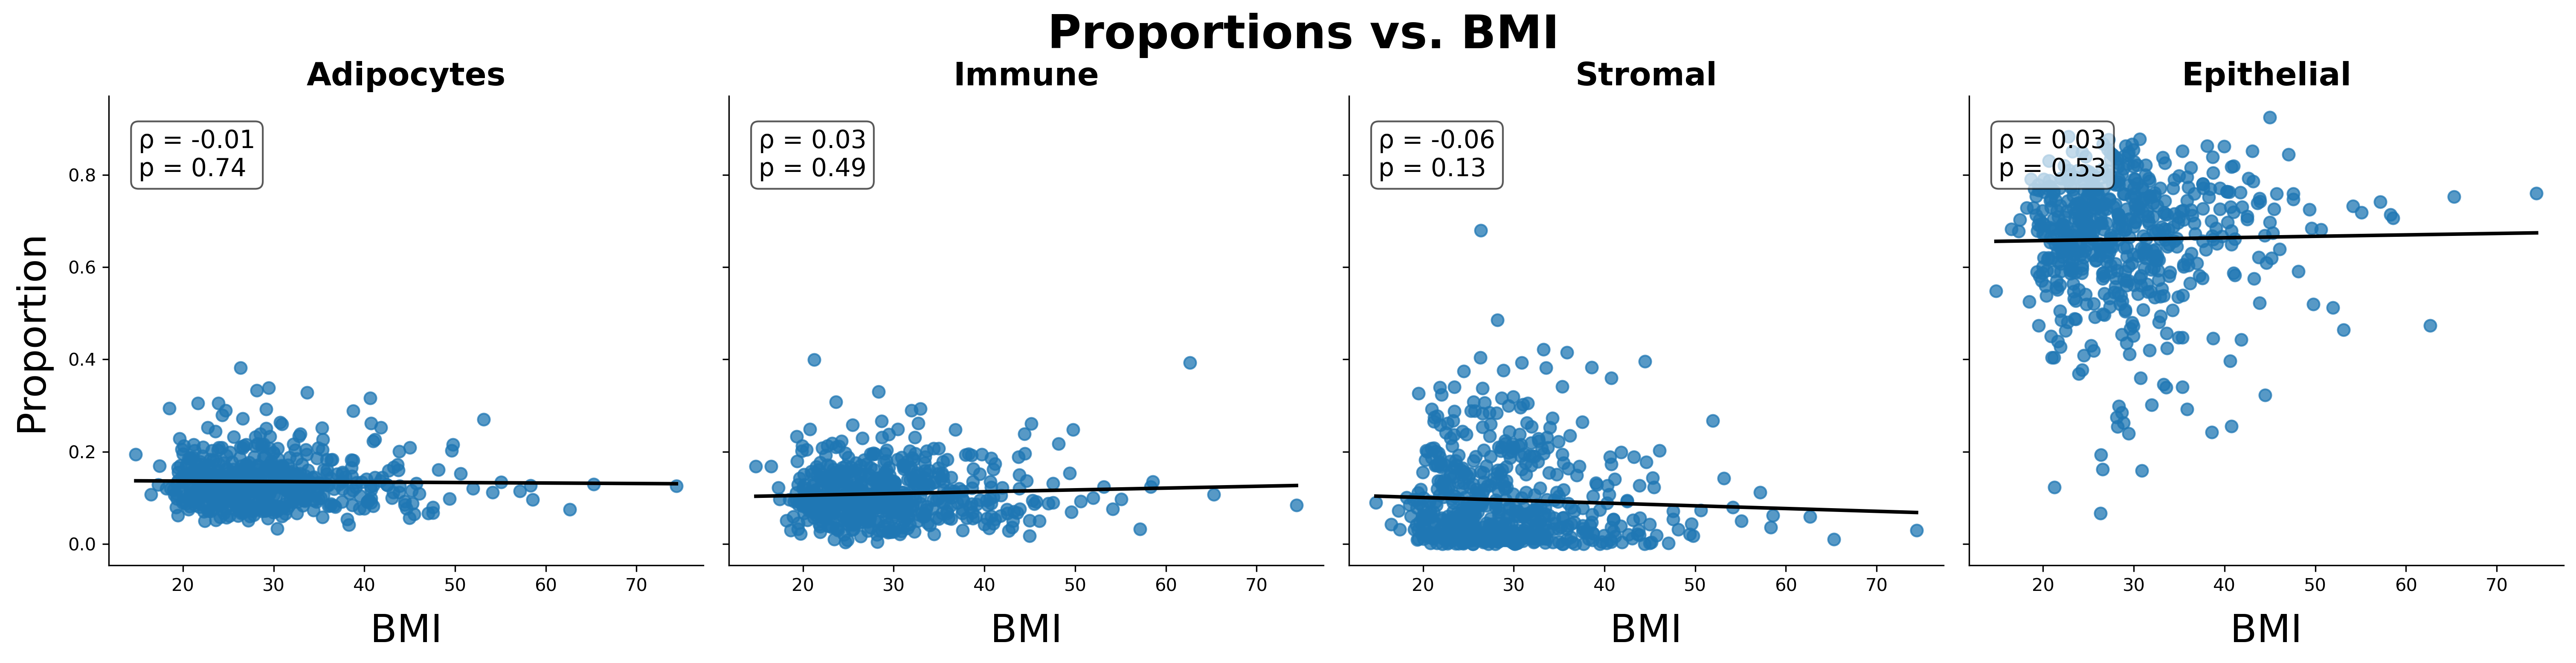

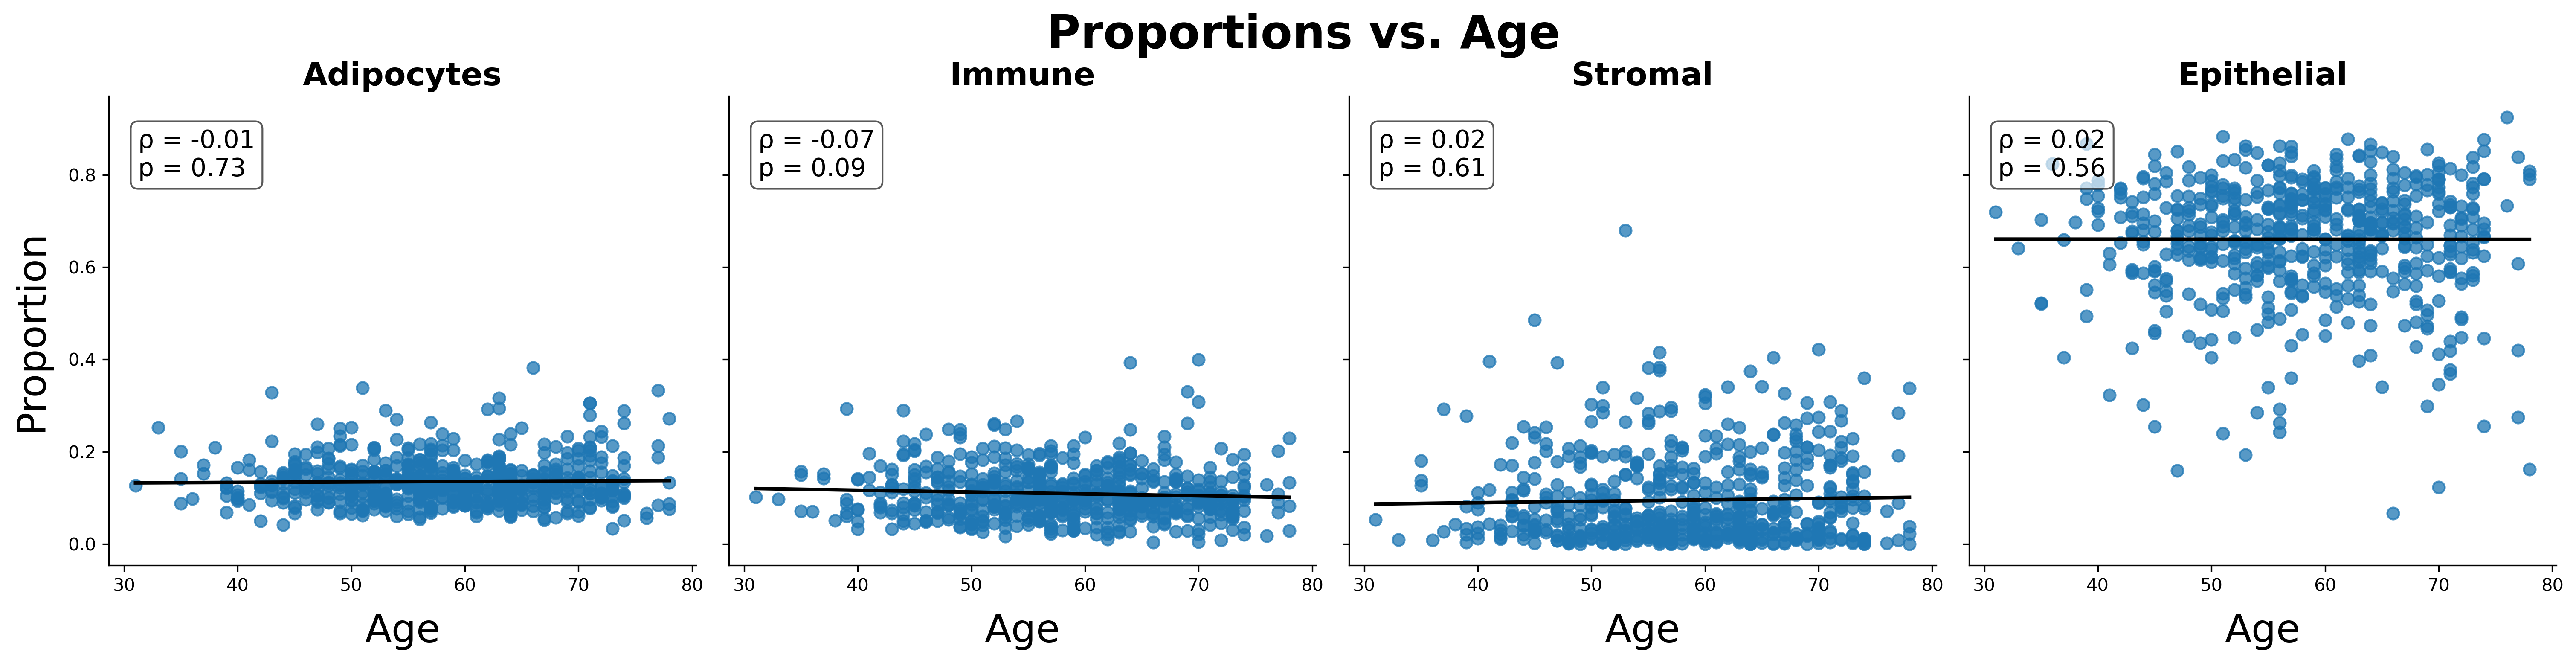

In [13]:
# ── 2.  Scatter/Trend plots ---------------------------------------------

for pred in predictors:                             # “BMI”, then “Age”
    # ---- pre-compute Spearman correlations  ------------------------------
    corr = {frac: spearmanr(macros[pred], macros[frac]) for frac in fractions}

    # ---- lmplot  ----------------------------------------------------------
    g = sns.lmplot(
        data   = macros.melt(id_vars=predictors, value_vars=fractions,
                             var_name="Fraction", value_name="Prop"),
        x      = pred,
        y      = "Prop",
        col    = "Fraction", ci=None,
        col_order = fractions,
        height = 5.0,          # ↑ taller panels
        aspect = 1.0,         # ↑ wider panels
        scatter_kws = dict(s=45, alpha=0.75),
        line_kws    = dict(color="black", linewidth=2),
    )

    # ---- titles & labels  -------------------------------------------------
    g.set_titles(col_template="{col_name}", size=18, weight="bold")

    # Explicitly set x- and y-label font sizes
    g.set_xlabels(pred, fontsize=22, labelpad=10)
    g.set_ylabels("Proportion", fontsize=22, labelpad=10)

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"Proportions vs. {pred}", fontsize=26, weight="bold")

    # ---- annotate each facet with ρ and p  --------------------------------
    for ax, frac in zip(g.axes.flatten(), fractions):
        rho, p = corr[frac]
        ax.text(
            0.05, 0.93,
            f"ρ = {rho:.2f}\n"
            f"p = {p:.2f}",
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=14,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.65)
        )

    # ---- high-resolution display or save  --------------------------------
    g.fig.set_dpi(300)                  # ↑ on-screen / inline resolution
    plt.show()

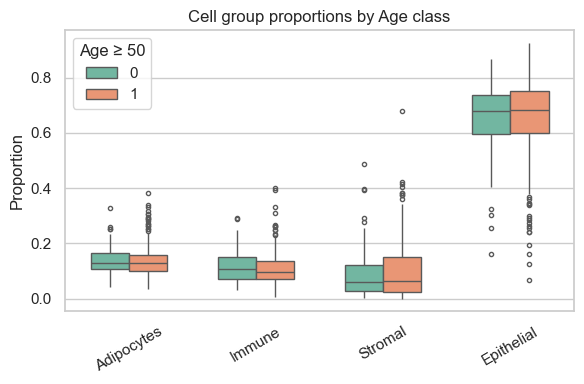

In [14]:
# 1 ── create a 0/1 Age flag  ───────────────────────────────────────────────
df["Age_high"] = (df["Age"] >= 50).astype(int)   # 0 = <50, 1 = ≥50

# arcsine–sqrt transform helper
asin = lambda p: np.arcsin(np.sqrt(np.clip(p, 0, 1)))

# tidy table for plotting
macro_cols = fractions
long = (df[["Age_high"] + macro_cols]
        .melt(id_vars="Age_high",
              var_name="Group", value_name="Prop"))


# 3 ── boxplots  ────────────────────────────────────────────────────────────
sns.set(style="whitegrid", palette="Set2")

plt.figure(figsize=(6,4))
sns.boxplot(data=long, x="Group", y="Prop",
            hue="Age_high",
            showcaps=False, fliersize=3, width=0.6)
plt.ylabel("Proportion")
plt.xlabel("")
plt.xticks(rotation=30)
plt.legend(title="Age ≥ 50")
plt.title("Cell group proportions by Age class")
plt.tight_layout()
plt.show()


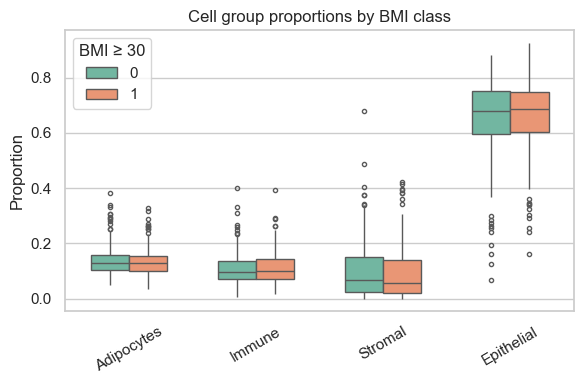

In [15]:
# 1 ── create a 0/1 BMI flag  ───────────────────────────────────────────────
df["BMI_high"] = (df["BMI"] >= 30).astype(int)   # 0 = <30, 1 = ≥30

# arcsine–sqrt transform helper
asin = lambda p: np.arcsin(np.sqrt(np.clip(p, 0, 1)))

# tidy table for plotting
long = (df[["BMI_high"] + macro_cols]
        .melt(id_vars="BMI_high",
              var_name="Group", value_name="Prop"))


# 3 ── boxplots  ────────────────────────────────────────────────────────────
sns.set(style="whitegrid", palette="Set2")

plt.figure(figsize=(6,4))
sns.boxplot(data=long, x="Group", y="Prop",
            hue="BMI_high",
            showcaps=False, fliersize=3, width=0.6)
plt.ylabel("Proportion")
plt.xlabel("")
plt.xticks(rotation=30)
plt.legend(title="BMI ≥ 30")
plt.title("Cell group proportions by BMI class")
plt.tight_layout()
plt.show()


Standardising (z-scores) lets you say “a 1-SD increase in BMI has < 1 % change in fraction” and makes the βs for BMI and Age directly comparable.

In [16]:
predictors = ["BMI", "Age"]

df = df[fractions + predictors].copy()
df

,Adipocytes,Immune,Stromal,Epithelial,BMI,Age
ID,,,,,,
40143,0.113422,0.218528,5.741863e-02,0.610632,23.218229,63
41377,0.169611,0.096819,3.138082e-02,0.702189,17.428942,54
41387,0.064832,0.086715,1.228492e-01,0.725604,45.470350,55
41391,0.119373,0.107769,1.118747e-01,0.660983,31.340800,60
41435,0.110333,0.087462,6.225249e-02,0.739953,23.922658,59
...,...,...,...,...,...,...
310266,0.097551,0.049467,7.507748e-02,0.777904,28.349557,40
320012,0.135411,0.093217,9.157968e-51,0.771372,37.677475,66
320025,0.181209,0.134981,2.364402e-02,0.660166,38.740537,60


In [17]:
# %% --- Beta-regression: BMI & Age vs each macro fraction --------------
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel     # ← correct import
from statsmodels.stats.multitest import multipletests


results = []

for frac in fractions:                       # e.g. ['Adipocytes', 'Immune', …]
    y = df[frac].values                      # proportions in (0, 1)
    X = sm.add_constant(df[["BMI", "Age"]])  # z-scored predictors + intercept

    # mean-only beta regression (logit link is default)
    model = BetaModel(y, X).fit()

    # collect coefficients, CIs, p-values
    for pred in ["BMI", "Age"]:
        results.append({
            "Fraction" : frac,
            "Predictor": pred,
            "Beta"     : model.params[pred],
            "CI_low"   : model.conf_int().loc[pred, 0],
            "CI_high"  : model.conf_int().loc[pred, 1],
            "p_raw"    : model.pvalues[pred]
        })

# organise results
coef_df = pd.DataFrame(results)

# ── Benjamini–Hochberg (8 tests) ----------------------------------------
coef_df["p_adj"] = multipletests(coef_df["p_raw"], method="bonferroni")[1]
coef_df

,Fraction,Predictor,Beta,CI_low,CI_high,p_raw,p_adj
0,Adipocytes,BMI,-0.001328,-0.005536,0.002879,0.536081,1.000000
1,Adipocytes,Age,-0.000130,-0.003571,0.003311,0.940851,1.000000
2,Immune,BMI,0.002420,-0.003220,0.008060,0.400308,1.000000
3,Immune,Age,-0.004860,-0.009466,-0.000253,0.038673,0.309385
4,Stromal,BMI,-0.020026,-0.031558,-0.008494,0.000665,0.005321
5,Stromal,Age,-0.018767,-0.027126,-0.010407,0.000011,0.000087
6,Epithelial,BMI,0.001932,-0.003947,0.007810,0.519511,1.000000
7,Epithelial,Age,0.000417,-0.004389,0.005223,0.865054,1.000000


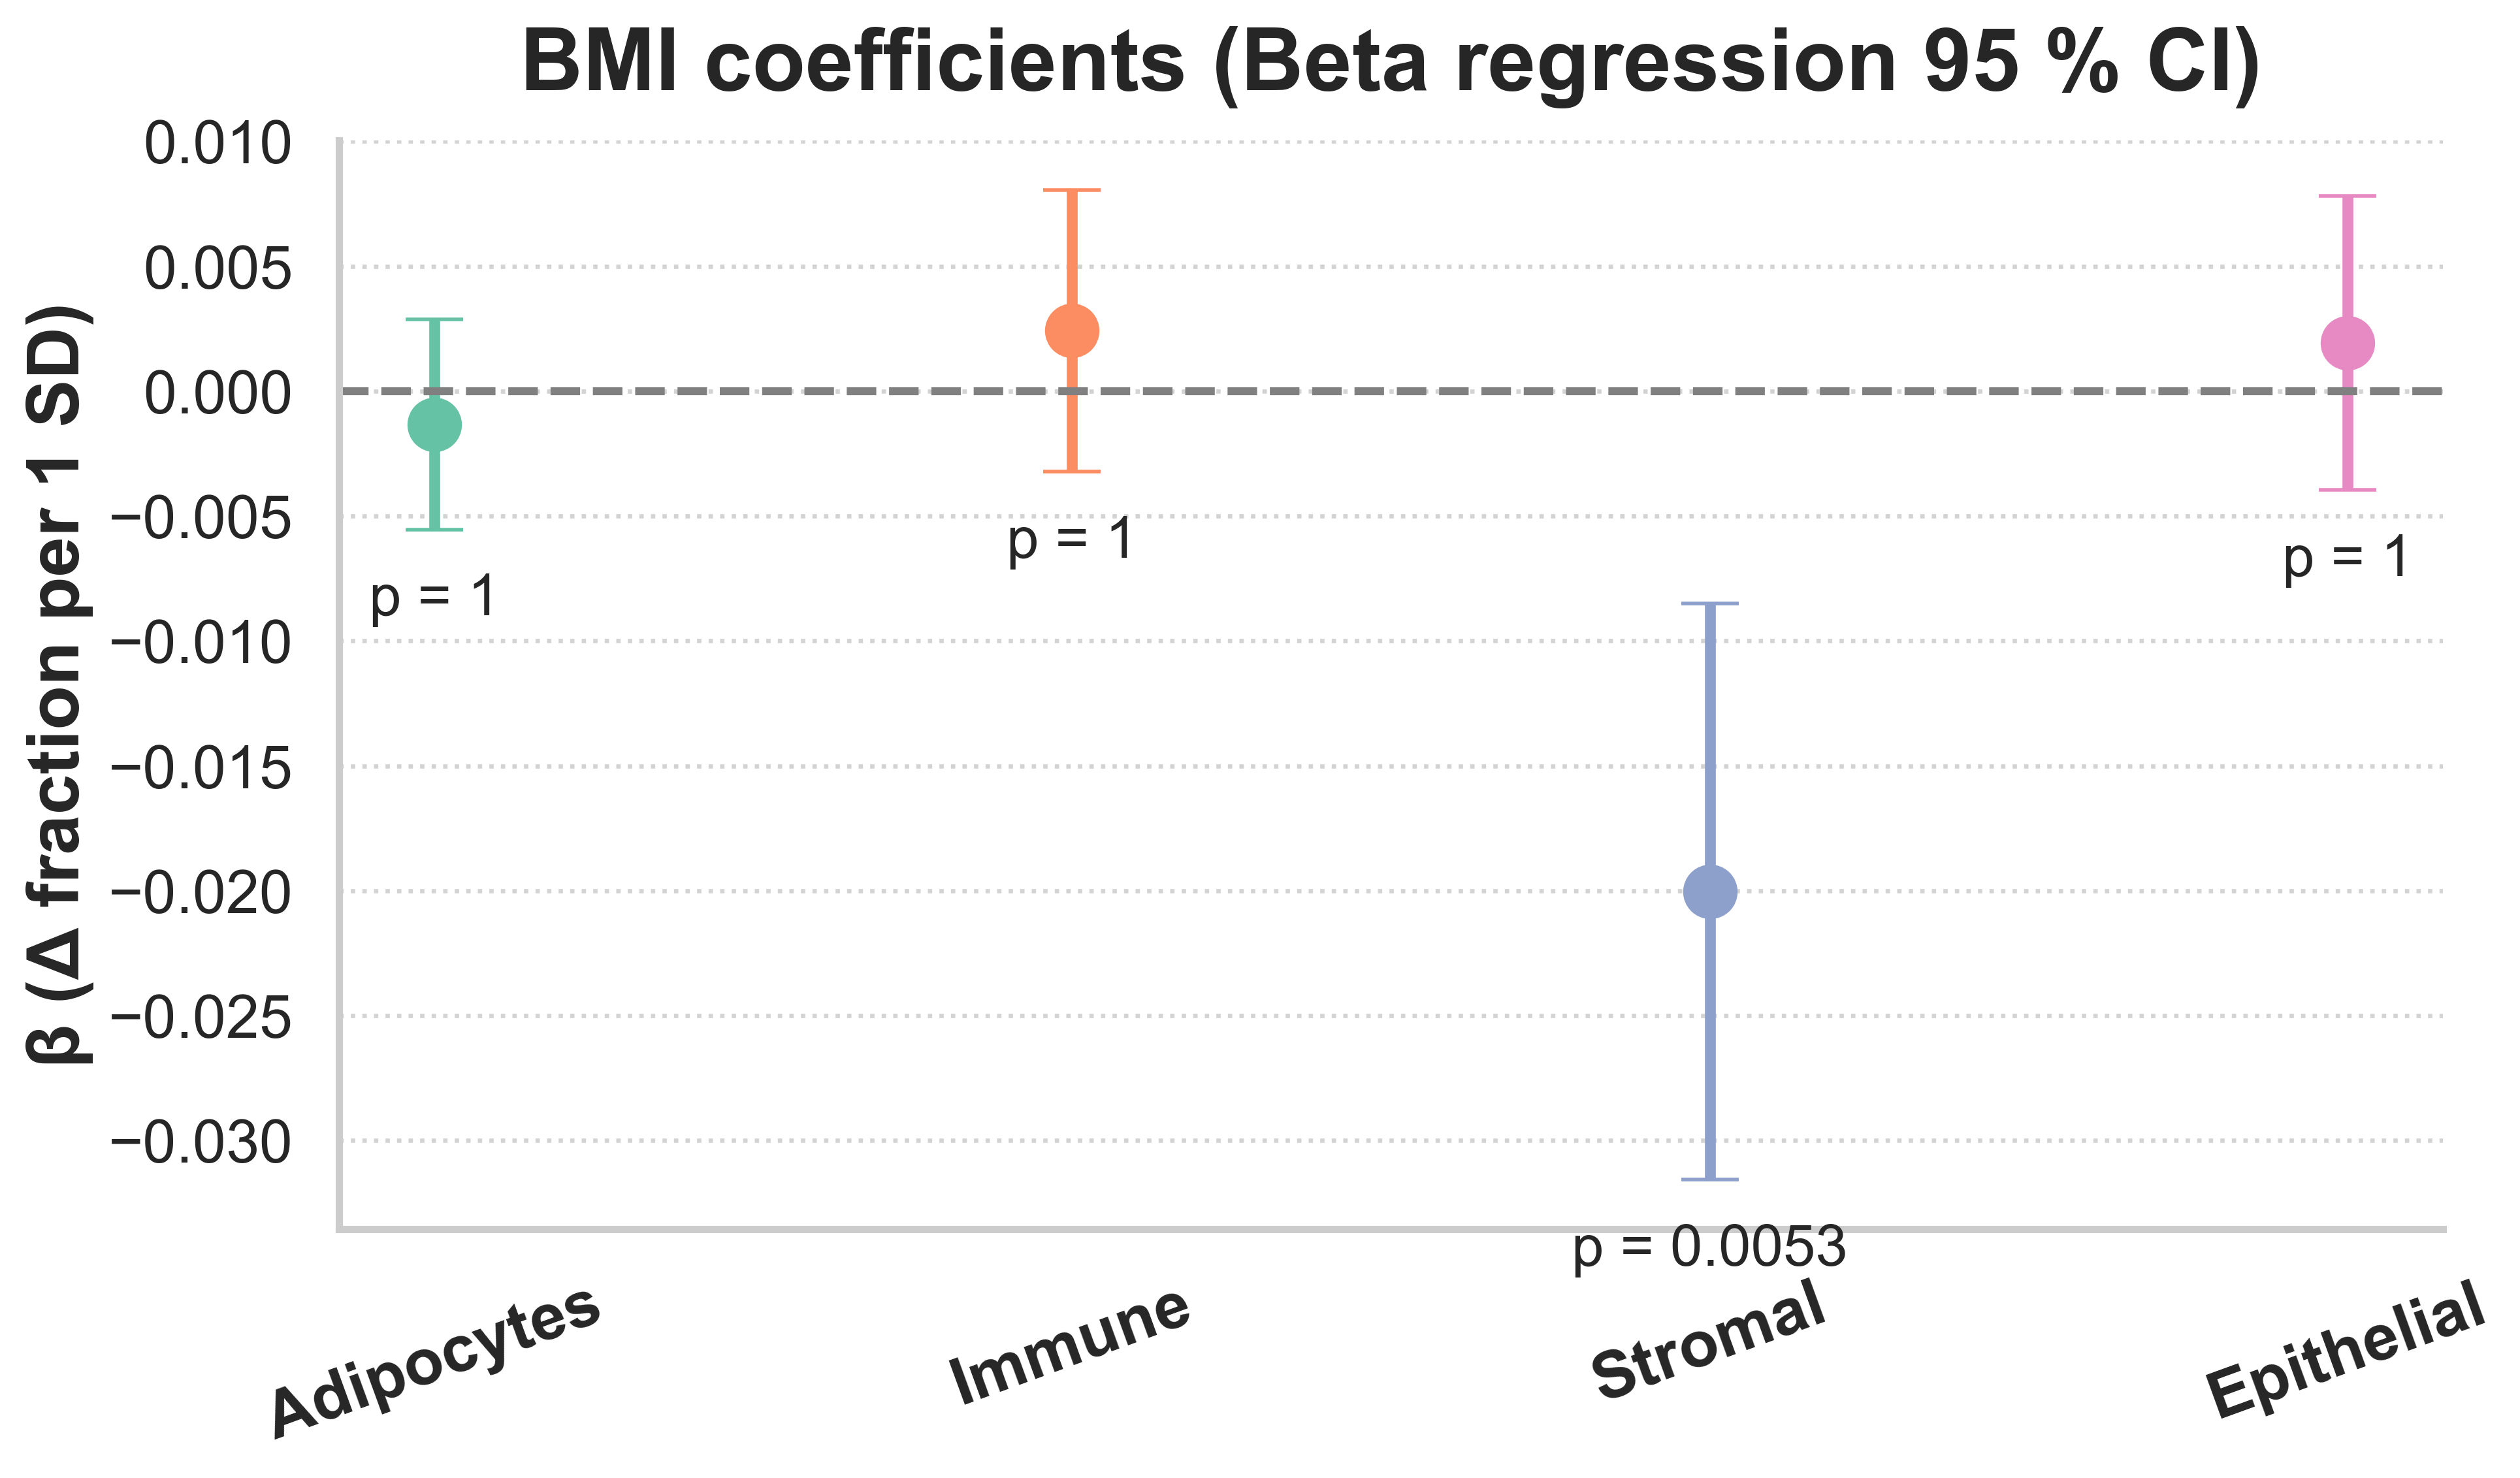

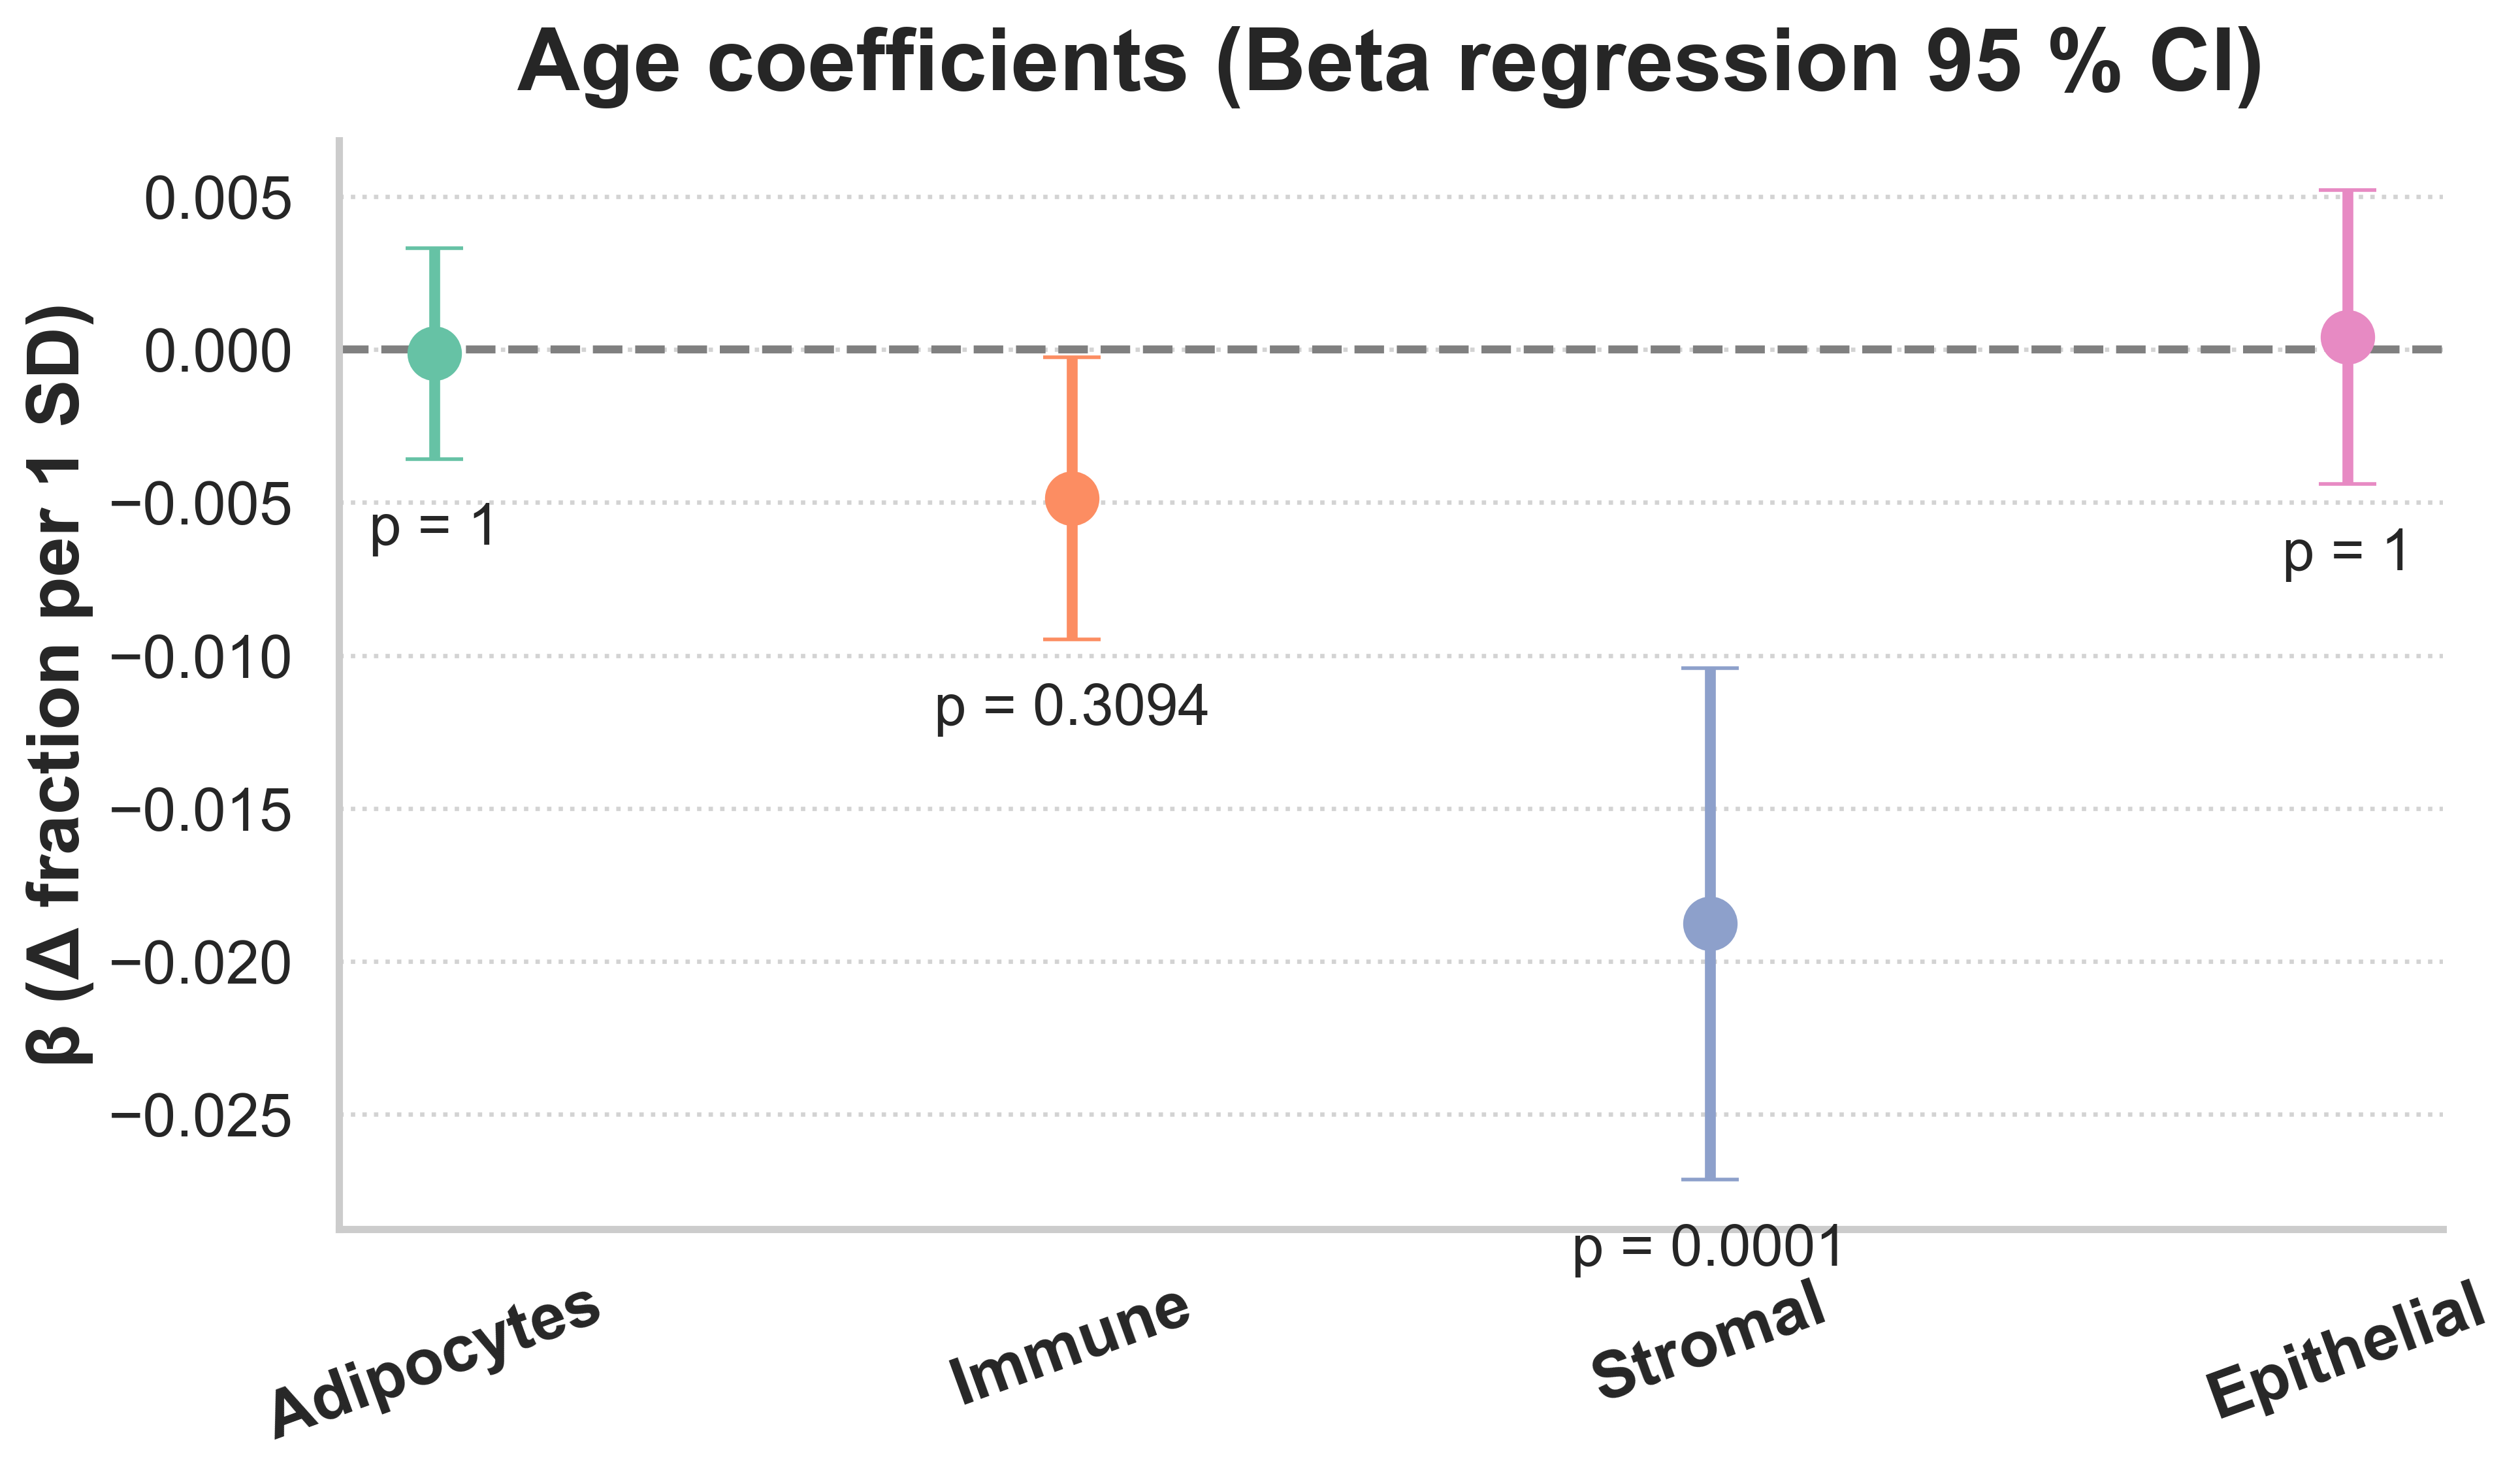

In [18]:
# %% --- Coefficient plots (large & clean) --------------------------------
sns.set_theme(style="whitegrid", context="talk")

plt.rcParams.update({
    "font.size"        : 18,
    "axes.labelweight" : "bold",
    "axes.titlesize"   : 24,
    "axes.titleweight" : "bold",
    "axes.linewidth"   : 2.0,
    "xtick.major.width": 1.8,
    "ytick.major.width": 1.8,
})

for pred in ["BMI", "Age"]:
    fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

    subset  = coef_df[coef_df.Predictor == pred]
    colours = sns.color_palette("Set2", len(fractions))

    for i, (_, row) in enumerate(subset.iterrows()):
        ax.errorbar(
            i, row["Beta"],
            yerr=[[row["Beta"] - row["CI_low"]],
                  [row["CI_high"] - row["Beta"]]],
            fmt="o", markersize=14, capsize=8, linewidth=3,
            color=colours[i], ecolor=colours[i], elinewidth=3
        )
        p_txt = "p = 1" if row["p_adj"] == 1 else f"p = {row['p_adj']:.4f}"
        ax.annotate(
            p_txt,
            xy=(i, row["CI_low"]), xytext=(0, -12),
            textcoords="offset points",
            ha="center", va="top", fontsize=16
        )

    ax.axhline(0, ls="--", color="gray", lw=2.2)

    ax.set_xticks(range(len(fractions)))
    ax.set_xticklabels(fractions, rotation=20, weight="bold", fontsize=18)
    ax.set_ylabel("β (Δ fraction per 1 SD)", weight="bold", fontsize=20)
    ax.set_title(f"{pred} coefficients (Beta regression 95 % CI)", pad=14)

    # --- tidy grid ------------------------------------------------------ 💡 CHANGED
    ax.set_facecolor("white")            # wipe background stripes
    ax.grid(False)
    ax.grid(axis="y", which="major",
            linestyle=":", linewidth=1.2, color="lightgray", zorder=0)

    sns.despine(ax=ax, trim=False)       # keep full bottom & left spines 💡 CHANGED
    fig.tight_layout()
    plt.show()